# Lab session 2: data preprocessing

## Introduction 

The purpose of this lab session is to provide you with an opportunity to gain experience with **data preprocessing**, and more specifically with the concepts of **handling missing values**, **handling noisy data**, **data normalisation**, **aggregation**, **sampling**, and **discretisation**. 

This session starts with a tutorial that uses examples to introduce you to the practical knowledge that you will need for the corresponding assignment. We highly recommend that you read the following tutorials if you need a gentler introduction to the libraries that we use:
- [Numpy quickstart tutorial](https://numpy.org/devdocs/user/quickstart.html)
- [Numpy: basic broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html)
- [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html)
- [Matplotlib](https://matplotlib.org/tutorials/introductory/pyplot.html)
- [Seaborn](https://seaborn.pydata.org/tutorial/relational.html)
- [Scikit-learn](https://scikit-learn.org/stable/tutorial/basic/tutorial.html)

## Submission instructions

- The last section of this notebook includes the assessed assignment for day 1.
- There will be 4 assessed assignments. Each assignment corresponds to 10% of your final grade.
- The exam corresponds to the remaining 60% of your final grade.
- **PLAGIARISM** <ins>leads to irreversible non-negotiable failure in the module</ins> (if you are unsure about what constitutes plagiarism, please ask). 
- The deadline for submitting each assignment is defined on QM+.
- Penalties for late submissions will be applied in accordance with the School policy. The submission cut-off date is 7 days after the deadline.
- You should submit a **report** with your solutions to the assignment included in the last section of this notebook. The report should be a single **pdf** file. Other formats (such as doc, docx, or ipynb) are **not** acceptable. 
- The report should be excellently organized and identified with your name, student number, assignment number, and module identifier. When applicable, question numbers should precede the corresponding answers. 
- Please name your report file according to the following convention: Assignment[Number]-[Student Name]-[Student Number].pdf
- Submissions should be made through QM+. Submissions by e-mail will be ignored.
- Please always check whether the report file was uploaded correctly to QM+.
- Cases of **extenuating circumstances** have to go through the proper procedure in accordance with the School policy. Only cases approved by the School in due time will be considered.

## 1. Data quality issues

Poor data quality can have an adverse effect on data mining. Among the common data quality issues are noise, outliers, missing values, and duplicate data. This section presents examples of Python code to alleviate some of these data quality problems. We begin with an example dataset from the UCI machine learning repository containing information about breast cancer patients. We will first download the dataset using the Pandas read_csv() function and display its first 5 data points.

In [ ]:
import pandas as pd
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', header=None)
data.columns = ['Sample code', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape',
                'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
                'Normal Nucleoli', 'Mitoses','Class']

data = data.drop(['Sample code'],axis=1)
print('Number of instances = %d' % (data.shape[0]))
print('Number of features = %d' % (data.shape[1]))
data.head()

Number of instances = 699
Number of features = 10


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


### 1.1 Missing Values

It is not unusual for an object to be missing one or more feature values. In some cases, the information was not collected; while in other cases, some features are inapplicable to the data instances. This section presents examples on the different approaches for handling missing values. 

According to the description of the data (https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)), the missing values are encoded as '?' in the original data. Our first task is to convert the missing values to NaNs. We can then count the number of missing values in each column of the data.

In [ ]:
import numpy as np

data = data.replace('?',np.NaN)

print('Number of instances = %d' % (data.shape[0]))
print('Number of features = %d' % (data.shape[1]))

print('Number of missing values:')
for col in data.columns:
    print('\t%s: %d' % (col,data[col].isna().sum()))

Number of instances = 699
Number of features = 10
Number of missing values:
	Clump Thickness: 0
	Uniformity of Cell Size: 0
	Uniformity of Cell Shape: 0
	Marginal Adhesion: 0
	Single Epithelial Cell Size: 0
	Bare Nuclei: 16
	Bland Chromatin: 0
	Normal Nucleoli: 0
	Mitoses: 0
	Class: 0


Observe that only the 'Bare Nuclei' column contains missing values. In the following example, the missing values in the 'Bare Nuclei' column are replaced by the median value of that column. The values before and after replacement are shown for a subset of the data points.

In [ ]:
data2 = data['Bare Nuclei']

print('Before replacing missing values:')
print(data2[20:25])
data2 = data2.fillna(data2.median())

print('\nAfter replacing missing values:')
print(data2[20:25])

Before replacing missing values:
20     10
21      7
22      1
23    NaN
24      1
Name: Bare Nuclei, dtype: object

After replacing missing values:
20    10
21     7
22     1
23     1
24     1
Name: Bare Nuclei, dtype: object


Instead of replacing the missing values, another common approach is to discard the data points that contain missing values. This can be easily accomplished by applying the dropna() function to the data frame.

In [ ]:
print('Number of rows in original data = %d' % (data.shape[0]))

data2 = data.dropna()
print('Number of rows after discarding missing values = %d' % (data2.shape[0]))

Number of rows in original data = 699
Number of rows after discarding missing values = 683


### 1.2 Outliers

Outliers are observations with characteristics that are considerably different from the rest of the dataset. In the example code below, we will draw a boxplot to identify the columns in the table that contain outliers. Note that the values in all columns (except for 'Bare Nuclei') are originally stored as 'int64' whereas the values in the 'Bare Nuclei' column are stored as string objects (since the column initially contains strings such as '?' for representing missing values). Thus, we must  convert the column into numeric values first before creating the boxplot. Otherwise, the column will not be displayed when drawing the boxplot.

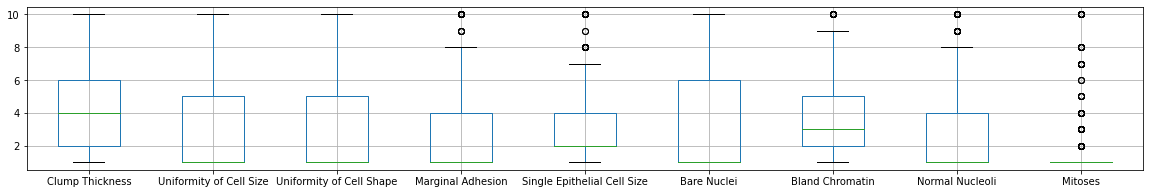

In [ ]:
data2 = data.drop(['Class'],axis=1)
data2['Bare Nuclei'] = pd.to_numeric(data2['Bare Nuclei'])
data2.boxplot(figsize=(20,3))

The boxplots suggest that only 5 of the columns (Marginal Adhesion, Single Epithetial Cell Size, Bland Cromatin, Normal Nucleoli, and Mitoses) contain abnormally high values. To discard the outliers, we can standardize each feature and remove those instances containing features with abnormally high or low value (e.g., larger than 3 or smaller than -3)

The following code shows the results of standardizing the columns of the data. Note that missing values (NaN) are not affected by the standardization process.

In [ ]:
data2.std()

Clump Thickness                2.815741
Uniformity of Cell Size        3.051459
Uniformity of Cell Shape       2.971913
Marginal Adhesion              2.855379
Single Epithelial Cell Size    2.214300
Bare Nuclei                    3.643857
Bland Chromatin                2.438364
Normal Nucleoli                3.053634
Mitoses                        1.715078
dtype: float64

In [ ]:
Z = (data2-data2.mean())/data2.std()
Z[20:25]

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
20,0.917080,-0.044070,-0.406284,2.519152,0.805662,1.771569,0.640688,0.371049,1.405526
21,1.982519,0.611354,0.603167,0.067638,1.257272,0.948266,1.460910,2.335921,-0.343666
22,-0.503505,-0.699494,-0.742767,-0.632794,-0.549168,-0.698341,-0.589645,-0.611387,-0.343666
23,1.272227,0.283642,0.603167,-0.632794,-0.549168,NaN,1.460910,0.043570,-0.343666
24,-1.213798,-0.699494,-0.742767,-0.632794,-0.549168,-0.698341,-0.179534,-0.611387,-0.343666


### 1.3 Duplicate Data

Some datasets, especially those obtained by merging multiple data sources, may contain duplicates or near duplicate instances. The term deduplication is often used to refer to the process of dealing with duplicate data issues. In the following example, we first check for duplicate instances in the breast cancer dataset.

In [ ]:
data.duplicated()

In [ ]:
dups = data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
data.loc[[11,28]]

Number of duplicate rows = 236


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
11,2,1,1,1,2,1,2,1,1,2
28,2,1,1,1,2,1,2,1,1,2


The duplicated() function will return a Boolean array that indicates whether each row is a duplicate of a previous row in the table. The results suggest there are 236 duplicate rows in the breast cancer dataset. For example, the instance with row index 11 has identical feature values as the instance with row index 28. Although such duplicate rows may correspond to samples for different individuals, in this hypothetical example, we assume that the duplicates are samples taken from the same individual and illustrate below how to remove the duplicated rows.

In [ ]:
print('Number of rows before discarding duplicates = %d' % (data.shape[0]))
data_deduplicated = data.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (data_deduplicated.shape[0]))

Number of rows before discarding duplicates = 699
Number of rows after discarding duplicates = 463


## 2. Aggregation

Data aggregation is a preprocessing task where the values of two or more objects are combined into a single object. The motivation for aggregation includes (1) reducing the size of data to be processed, (2) changing the granularity of analysis (from fine-scale to coarser-scale), and (3) improving the stability of the data.

In the example below, we will use the daily precipitation time series data for a weather station located at Detroit Metro Airport (data/DTW_prec.csv). The raw data was obtained from the Climate Data Online website (https://www.ncdc.noaa.gov/cdo-web/). The daily precipitation time series will be compared against its monthly values.

The code below will load the precipitation time series data and draw a line plot of its daily time series. You will need to upload the ''CSV'' file to the virtual machine as in the previous lab session.

Text(0.5, 1.0, 'Daily Precipitation (variance = 0.0530)')

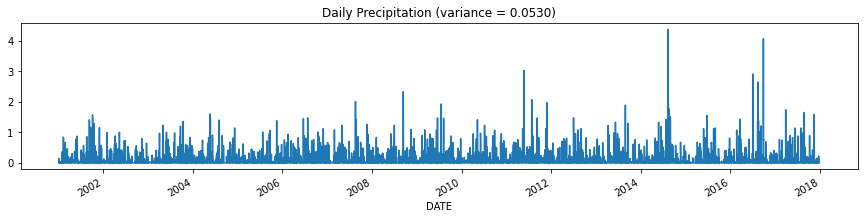

In [ ]:
daily = pd.read_csv('DTW_prec.csv', header='infer')
daily.index = pd.to_datetime(daily['DATE'])
daily = daily['PRCP']
ax = daily.plot(kind='line',figsize=(15,3))
ax.set_title('Daily Precipitation (variance = %.4f)' % (daily.var()))

Observe that the daily time series appear to be quite chaotic and varies significantly from one time step to another. The time series can be grouped and aggregated by month to obtain the total monthly precipitation values. The resulting time series appears to vary more smoothly compared to the daily time series.

Text(0.5, 1.0, 'Monthly Precipitation (variance = 2.4241)')

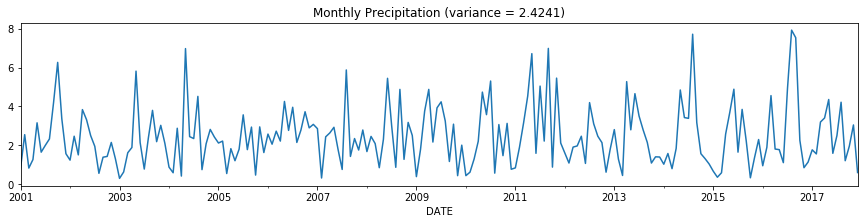

In [ ]:
monthly = daily.groupby(pd.Grouper(freq='M')).sum()
ax = monthly.plot(kind='line',figsize=(15,3))
ax.set_title('Monthly Precipitation (variance = %.4f)' % (monthly.var()))

In the example below, the daily precipitation time series are grouped and aggregated by year to obtain the annual precipitation values. 

Text(0.5, 1.0, 'Annual Precipitation (variance = 23.6997)')

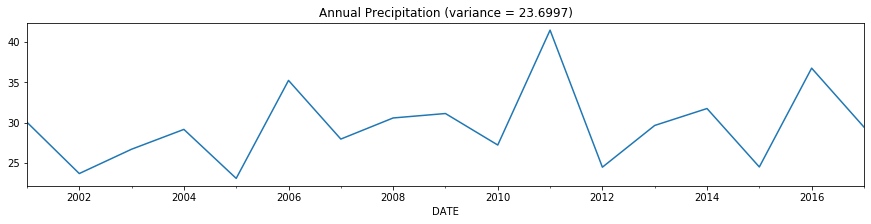

In [ ]:
annual = daily.groupby(pd.Grouper(freq='Y')).sum()
ax = annual.plot(kind='line',figsize=(15,3))
ax.set_title('Annual Precipitation (variance = %.4f)' % (annual.var()))

## 3. Sampling

Sampling is an approach commonly used to facilitate (1) data reduction for exploratory data analysis and scaling up algorithms to big data applications and (2) quantifying uncertainties due to varying data distributions. There are various methods available for data sampling, such as sampling without replacement, where each selected instance is removed from the dataset, and sampling with replacement, where each selected instance is not removed, thus allowing it to be selected more than once.

In the example below, we will apply sampling with replacement and without replacement to the breast cancer dataset obtained from the UCI machine learning repository. We initially display the first five records of the table.

In [ ]:
data.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In the following code, a sample of size 3 is randomly selected (without replacement) from the original data.

In [ ]:
sample = data.sample(n=3)
sample

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
66,4,1,1,1,2,1,3,1,1,2
221,10,6,4,3,10,10,9,10,1,4
53,5,5,5,8,10,8,7,3,7,4


In the next example, we randomly select 1% of the data (without replacement) and display the selected samples. The random_state argument of the function specifies the seed value of the random number generator, which allows reproducibility.

In [ ]:
sample = data.sample(frac=0.01, random_state=1)
sample

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
584,5,1,1,6,3,1,1,1,1,2
417,1,1,1,1,2,1,2,1,1,2
606,4,1,1,2,2,1,1,1,1,2
349,4,2,3,5,3,8,7,6,1,4
134,3,1,1,1,3,1,2,1,1,2
502,4,1,1,2,2,1,2,1,1,2
117,4,5,5,10,4,10,7,5,8,4


Finally, we perform a sampling with replacement to create a sample whose size is equal to 1% of the entire data. You should be able to observe duplicate instances in the sample by increasing the sample size.

In [ ]:
sample = data.sample(frac=0.01, replace=True, random_state=1)
sample

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
37,6,2,1,1,1,1,7,1,1,2
235,3,1,4,1,2,NaN,3,1,1,2
72,1,3,3,2,2,1,7,2,1,2
645,3,1,1,1,2,1,2,1,1,2
144,2,1,1,1,2,1,2,1,1,2
129,1,1,1,1,10,1,1,1,1,2
583,3,1,1,1,2,1,1,1,1,2


## 4. Discretization

Discretization is a data preprocessing step that is often used to transform a continuous-valued feature to a categorical feature. The example below illustrates two simple but widely-used unsupervised discretization methods (equal width and equal depth) applied to the 'Clump Thickness' feature of the breast cancer dataset.

First, we plot a histogram that shows the distribution of the feature values. The value_counts() function can also be applied to count the frequency of each feature value.

1     145
2      50
3     108
4      80
5     130
6      34
7      23
8      46
9      14
10     69
Name: Clump Thickness, dtype: int64

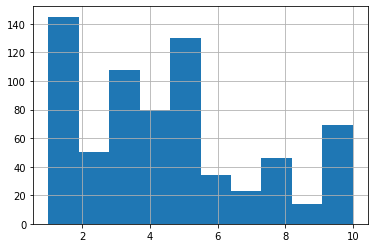

In [ ]:
data['Clump Thickness'].hist(bins=10)
data['Clump Thickness'].value_counts(sort=False)

For the equal width method, we can apply the cut() function to discretize the feature into 4 bins of similar interval widths. The value_counts() function can be used to determine the number of instances in each bin.

In [ ]:
bins = pd.cut(data['Clump Thickness'],4)
bins.value_counts(sort=False)

(0.991, 3.25]    303
(3.25, 5.5]      210
(5.5, 7.75]       57
(7.75, 10.0]     129
Name: Clump Thickness, dtype: int64

For the equal frequency method, the qcut() function can be used to partition the values into 4 bins such that each bin has nearly the same number of instances.

In [ ]:
bins = pd.qcut(data['Clump Thickness'],4)
bins.value_counts(sort=False)

(0.999, 2.0]    195
(2.0, 4.0]      188
(4.0, 6.0]      164
(6.0, 10.0]     152
Name: Clump Thickness, dtype: int64

## Assignment 1

1. Consider the following values for a feature: [2, 15, 20, 5, 1, 4, 7, 9, 10, 3, 14, 8]. Apply the following binning techniques: 
  1. Equal-frequency binning [0.5/10]
  2. Equal-width binning [0.5/10]
  
2. Use each of the methods listed below to normalize the following values for a feature: [10, 20, 35, 70, 100]
  1. Scaling with a mininum at 0 and a maximum at 1 [0.5/10]
  2. Standardization [0.5/10]
  
  
3. Suppose that a hospital has kept records of the age and BMI (Body Mass Index) of 16 randomly selected individuals. This data is presented below. Compute the correlation coefficient between the two features. Are the two features positively or negatively correlated? [1/10]

| Age  | 23  | 23  | 27  | 27  | 39  | 41  | 47  | 49  | 52  | 54  | 54  | 56  | 57  | 58  | 58  | 60  |
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
| BMI  | 16  | 19  | 18  | 21  | 24  | 23  | 26  | 25  | 24  | 26  | 23  | 26  | 27  | 31  | 26  | 27  |


5. Load the CSV file "data/BL_books.csv", which includes records of books hosted at the British Library. Inspect the data and describe any data issues observed. Remove fields that refer to internal processes at the British Library and do not describe the books themselves (Corporate Author, Corporate Contributors, Issuance type, Former owner, Shelfmarks, Engraver). Clean data in the column ``Date of Publication`` in order to remove the extra dates in square brackets (e.g., 1879 [1878] -> 1879), and convert date ranges to their start date, wherever present (e.g., 1860-63 -> 1860). [2/10]


6. Load the CSV file "data/country-income.csv", which includes both numerical and categorical values. Perform data cleaning in order to replace any NaN values with the mean of the value for a given feature. Then replace any categorical labels with numerical labels. Display the resulting dataset. You can use the packages sklearn.impute and sklearn.preprocessing to assist you. [2/10]


7. Load the CSV file "data/shoesize.csv", which includes measurements of shoe size and height (in inches) for 408 subjects, both female and male. Create scatterplots of shoe size versus height separately for female and male subjects. Compute the correlation coefficient between shoe size and height separately for female and male subjects. What can be inferred from the scatterplots and the correlation coefficients? You can implement your own formulation of the correlation coefficient or use the method ``DataFrame.corr`` to assist you. [3/10]


1 . Consider the following values for a feature: [2, 15, 20, 5, 1, 4, 7, 9, 10, 3, 14, 8]. Apply the following binning techniques:

Equal-frequency binning 

Equal-width binning 

In [ ]:
import pandas as pd
a=[2, 15, 20, 5, 1, 4, 7, 9, 10, 3, 14, 8]
print ("Equal Frequency binnning using qcut")
bins = pd.qcut(a,3)
bins.value_counts()

Equal Frequency binnning using qcut


(0.999, 4.667]    4
(4.667, 9.333]    4
(9.333, 20.0]     4
dtype: int64

In [ ]:
print("Equal-width binning using cut")
bins = pd.cut(a,3)
bins.value_counts()

Equal-width binning using cut


(0.981, 7.333]     6
(7.333, 13.667]    3
(13.667, 20.0]     3
dtype: int64

2. Use each of the methods listed below to normalize the following values for a feature: [10, 20, 35, 70, 100]

        1. Scaling with a mininum at 0 and a maximum at 1

        2. Standardization


In [ ]:
import numpy as np
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

sampledata= [10, 20, 35, 70, 100]
b=normalize(sampledata)
print("The Normalized value with a minimum at 0 and a maximum at 1")
print(b)

The Normalized value with a minimum at 0 and a maximum at 1
[0.         0.11111111 0.27777778 0.66666667 1.        ]


In [ ]:
def standardize(data):
    return (data - np.average(data)) / np.std(data)

sampledata= [10, 20, 35, 70, 100]
b=standardize(sampledata)
print("The standardisation values are ")
print(b)

The standardisation values are 
[-1.10756603 -0.80822386 -0.3592106   0.68848699  1.5865135 ]


3.  Suppose that a hospital has kept records of the age and BMI (Body Mass Index) of 16 randomly selected individuals. This data is presented below. Compute the correlation coefficient between the two features. Are the two features positively or negatively correlated? 


Age	23	23	27	27	39	41	47	49	52	54	54	56	57	58	58	60


BMI	16	19	18	21	24	23	26	25	24	26	23	26	27	31	26	27


In [ ]:
import numpy as np
Age=np.array([23,23,27,27,39,41,47,49,52,54,54,56,57,58,58,60])
BMI=np.array([16,19,18,21,24,23,26,25,24,26,23,26,27,31,26,27])
r = np.corrcoef( Age,BMI)
print("The Age to BMI Correlation is " + str(r[0,1]) )
print("The Two features are postively correlated")


The Age to BMI Correlation is 0.8911082029151666
The Two features are postively correlated


5. Question

Load the CSV file "data/BL_books.csv", which includes records of books hosted at the British Library. Inspect the data and describe any data issues observed. Remove fields that refer to internal processes at the British Library and do not describe the books themselves (Corporate Author, Corporate Contributors, Issuance type, Former owner, Shelfmarks, Engraver). Clean data in the column Date of Publication in order to remove the extra dates in square brackets (e.g., 1879 [1878] -> 1879), and convert date ranges to their start date, wherever present (e.g., 1860-63 -> 1860).


In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 500)
df = pd.read_csv('BL-books.csv')
df.head(2)

,Identifier,Edition Statement,Place of Publication,Date of Publication,Publisher,Title,Author,Contributors,Corporate Author,Corporate Contributors,Former owner,Engraver,Issuance type,Flickr URL,Shelfmarks
0,206,NaN,London,1879 [1878],S. Tinsley & Co.,Walter Forbes. [A novel.] By A. A,A. A.,"FORBES, Walter.",NaN,NaN,NaN,NaN,monographic,http://www.flickr.com/photos/britishlibrary/ta...,British Library HMNTS 12641.b.30.
1,216,NaN,London; Virtue & Yorston,1868,Virtue & Co.,All for Greed. [A novel. The dedication signed...,"A., A. A.","BLAZE DE BURY, Marie Pauline Rose - Baroness",NaN,NaN,NaN,NaN,monographic,http://www.flickr.com/photos/britishlibrary/ta...,British Library HMNTS 12626.cc.2.


In [ ]:
df.shape

(8287, 15)

In [ ]:
df1=df.drop(['Corporate Author', 'Corporate Contributors', 'Issuance type', 'Former owner', 'Shelfmarks', 'Engraver'],axis=1)
df1.shape
#df1.head(2)

(8287, 9)

In [ ]:
dups = df1.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))


Number of duplicate rows = 0


In [ ]:
df1[df1.isnull().any(axis=1)]
#Total 7961 rows have null values out of 8287 rows

,Identifier,Edition Statement,Place of Publication,Date of Publication,Publisher,Title,Author,Contributors,Flickr URL
0,206,NaN,London,1879 [1878],S. Tinsley & Co.,Walter Forbes. [A novel.] By A. A,A. A.,"FORBES, Walter.",http://www.flickr.com/photos/britishlibrary/ta...
1,216,NaN,London; Virtue & Yorston,1868,Virtue & Co.,All for Greed. [A novel. The dedication signed...,"A., A. A.","BLAZE DE BURY, Marie Pauline Rose - Baroness",http://www.flickr.com/photos/britishlibrary/ta...
2,218,NaN,London,1869,"Bradbury, Evans & Co.",Love the Avenger. By the author of “All for Gr...,"A., A. A.","BLAZE DE BURY, Marie Pauline Rose - Baroness",http://www.flickr.com/photos/britishlibrary/ta...
3,472,NaN,London,1851,James Darling,"Welsh Sketches, chiefly ecclesiastical, to the...","A., E. S.","Appleyard, Ernest Silvanus.",http://www.flickr.com/photos/britishlibrary/ta...
6,519,NaN,London,1872,The Author,Lagonells. By the author of Darmayne (F. E. A....,"A., F. E.","ASHLEY, Florence Emily.",http://www.flickr.com/photos/britishlibrary/ta...
...,...,...,...,...,...,...,...,...,...
8282,4158088,NaN,London,1838,NaN,"The Parochial History of Cornwall, founded on,...","GIDDY, afterwards GILBERT, Davies.","BOASE, Henry Samuel.|HALS, William.|LYSONS, Da...",http://www.flickr.com/photos/britishlibrary/ta...
8283,4158128,NaN,Derby,"1831, 32",M. Mozley & Son,The History and Gazetteer of the County of Der...,"GLOVER, Stephen - of Derby","NOBLE, Thomas.",http://www.flickr.com/photos/britishlibrary/ta...
8284,4159563,NaN,London,[1806]-22,T. Cadell and W. Davies,Magna Britannia; being a concise topographical...,"LYSONS, Daniel - M.A., F.R.S., and LYSONS (Sam...","GREGSON, Matthew.|LYSONS, Samuel - F.R.S",http://www.flickr.com/photos/britishlibrary/ta...
8285,4159587,NaN,Newcastle upon Tyne,1834,Mackenzie & Dent,"An historical, topographical and descriptive v...","Mackenzie, E. (Eneas)","ROSS, M. - of Durham",http://www.flickr.com/photos/britishlibrary/ta...


In [ ]:
#a= str(df1["Date of Publication"])
a=str(['1879 [1878]','1831, 32','1834-43'])
#print(a)
head, sep, tail = a.partition(',')
print(tail)
type(a)

 '1831, 32', '1834-43']


str

Summary

1. Total zero rows are duplicate records in the given dataset
2. Total 7961 rows have null values out of 8287 rows

6. Load the CSV file "data/country-income.csv", which includes both numerical and categorical values. Perform data cleaning in order to replace any NaN values with the mean of the value for a given feature. Then replace any categorical labels with numerical labels. Display the resulting dataset. You can use the packages sklearn.impute and sklearn.preprocessing to assist you.

In [ ]:
CI = pd.read_csv('country-income.csv')
CI.head()

,Region,Age,Income,Online Shopper
0,India,49.0,86400.0,No
1,Brazil,32.0,57600.0,Yes
2,USA,35.0,64800.0,No
3,Brazil,43.0,73200.0,No
4,USA,45.0,NaN,Yes


In [ ]:
CI.shape
#find null values in the dataset
CI[CI.isnull().any(axis=1)]

,Region,Age,Income,Online Shopper
4,USA,45.0,NaN,Yes
6,Brazil,NaN,62400.0,No


In [ ]:
#Replace the null values with mean
CI_updated=CI.fillna(CI.mean())
CI_updated.head(10)

,Region,Age,Income,Online Shopper
0,India,49.000000,86400.000000,No
1,Brazil,32.000000,57600.000000,Yes
2,USA,35.000000,64800.000000,No
3,Brazil,43.000000,73200.000000,No
4,USA,45.000000,76533.333333,Yes
5,India,40.000000,69600.000000,Yes
6,Brazil,43.777778,62400.000000,No
7,India,53.000000,94800.000000,Yes
8,USA,55.000000,99600.000000,No
9,India,42.000000,80400.000000,Yes


In [ ]:
CI_updated.dtypes

Region             object
Age               float64
Income            float64
Online Shopper     object
dtype: object

In [ ]:
CI_updated["Region"].value_counts()

India     4
USA       3
Brazil    3
Name: Region, dtype: int64

In [ ]:
CI_updated["Online Shopper"].value_counts()

No     5
Yes    5
Name: Online Shopper, dtype: int64

In [ ]:
cleanup_nums = {"Region": {"India": 1, "USA": 2 ,"Brazil": 3},
                "Online Shopper": {"No": 1, "Yes": 2 }}


In [ ]:
CI_updated2=CI_updated.replace(cleanup_nums)

CI_updated2.head(10)

,Region,Age,Income,Online Shopper
0,1,49.000000,86400.000000,1
1,3,32.000000,57600.000000,2
2,2,35.000000,64800.000000,1
3,3,43.000000,73200.000000,1
4,2,45.000000,76533.333333,2
5,1,40.000000,69600.000000,2
6,3,43.777778,62400.000000,1
7,1,53.000000,94800.000000,2
8,2,55.000000,99600.000000,1
9,1,42.000000,80400.000000,2


Summary

Please find the summary of above dataset

1. The null values are replaced by mean value
2. Replaced categorical labels with numerical labels

7. Load the CSV file "data/shoesize.csv", which includes measurements of shoe size and height (in inches) for 408 subjects, both female and male. Create scatterplots of shoe size versus height separately for female and male subjects. Compute the correlation coefficient between shoe size and height separately for female and male subjects. What can be inferred from the scatterplots and the correlation coefficients? You can implement your own formulation of the correlation coefficient or use the method DataFrame.corr to assist you.

In [ ]:
sz=pd.read_csv('shoesize.csv')
sz.head(2)
#sz.shape

,Index,Gender,Size,Height
0,1,F,5.5,60.0
1,2,F,6.0,60.0


In [ ]:
sz.dtypes

Index       int64
Gender     object
Size      float64
Height    float64
dtype: object

In [ ]:
corrmat = sz.corr()
round(corrmat,2)

,Index,Size,Height
Index,1.00,0.90,0.95
Size,0.90,1.00,0.87
Height,0.95,0.87,1.00


In [ ]:
corrmat = sz.loc[sz['Gender'] == 'M'].corr()
round(corrmat,2)

,Index,Size,Height
Index,1.00,0.79,0.96
Size,0.79,1.00,0.77
Height,0.96,0.77,1.00


In [ ]:
corrmat = sz.loc[sz['Gender'] == 'F'].corr()
round(corrmat,2)

,Index,Size,Height
Index,1.00,0.77,0.97
Size,0.77,1.00,0.71
Height,0.97,0.71,1.00


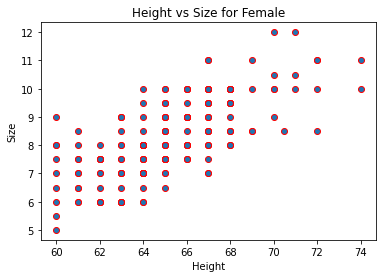

In [ ]:
import matplotlib.pyplot as plt
fig=plt.figure()
plt.scatter( sz.loc[sz['Gender'] == 'F']['Height'],sz.loc[sz['Gender'] == 'F']['Size'], edgecolors='r')
plt.xlabel('Height')
plt.ylabel('Size')
plt.title("Height vs Size for Female")
plt.show()

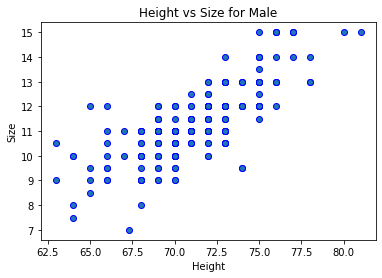

In [ ]:
import matplotlib.pyplot as plt
fig=plt.figure()
plt.scatter( sz.loc[sz['Gender'] == 'M']['Height'],sz.loc[sz['Gender'] == 'M']['Size'], edgecolors='b')
plt.xlabel('Height')
plt.ylabel('Size')
plt.title("Height vs Size for Male")
plt.show()


Summary

The following points are inferred from the scatter plot and correleation matrix

1. The height and shoe size have postive correleation 
2. The height and shoe size have 0.77 correlation factor for Male
3. The height and shoe size have 0.71 correlation factor for Female
